In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession

## Part A

Write a Python code that parses each SOU address, finding end-of-sentence markers.

In [2]:
spark = SparkSession.builder.master('local').appName('SOU').getOrCreate()
speeches = spark.read.json('/project/cmsc25025/sou/speeches.json')

# Split speech up by periods and put them into a list of lists [president, year, text]

speech = speeches.rdd.map(lambda x: (x['president'], int(x['year']), x['text'].split('.'))).collect()

Printing out president, year and first 2 sentences of the first SOU address.

In [8]:
# Example of one of the speeches
# President:
print "President:", speech[0][0]
print 
# Year:
print "Year:", speech[0][1]
print 
# First Sentence:
print "First sentence:"
print speech[0][2][0]

# Second Sentence:
print "Second sentence:"
print speech[0][2][1]

President: James Monroe

Year: 1821

First sentence:
 Fellow-Citizens of the Senate and House of Representatives:

 

The progress of our affairs since the last session has been such as may justly be claimed and expected under a Government deriving all its powers from an enlightened people, and under laws formed by their representatives, on great consideration, for the sole purpose of promoting the welfare and happiness of their constituents
Second sentence:
 In the execution of those laws and of the powers vested by the Constitution in the Executive, unremitted attention has been paid to the great objects to which they extend


## Part B

For each year, compute the number of sentences in the address, and the mean sentence
length in words for that year. Plot these data and two linear regressions, one
plot for the number of sentences by year, another for the average sentence length by
year.

In [43]:
# Defining functions to be used for counting number of sentences and calculating mean sentence length

def find_num_sentences(x):
    return int(len(x))
def find_mean_sentence_length(x):
    return float(np.average([len(k.split(' ')) for k in x]))

In [44]:
# MapReduce on RDD to get data in np.array form
# [Year, number of sentences, average words/sentence ]

speech = speeches.rdd.map(lambda x: [[int(x['year']), \
                                      find_num_sentences(x['text'].split('.')), \
                                      find_mean_sentence_length(x['text'].split('.'))]]).reduce(lambda a, b: a + b)
speech = np.array(speech)

In [45]:
# Running Linear Regression
# In order to use numpy.linalg.solve(), putting it in Ax=b form
# For simple linear regression, (X'X)b = X'y
# X1, Y1, left1 and right1 are all used for regression on year vs number of sentences
# X2, Y2, left2, and right2 are used for regression on year vs avg. word per sentence
# Note: added a column of 1s for X1, and X2

X1 = np.c_[np.array(speech[:,0]), np.ones(len(speech[:,0]))]
Y1 = np.array(speech[:,1])
X2 = np.c_[np.array(speech[:,0]), np.ones(len(speech[:,0]))]
Y2 = np.array(speech[:,2])

left1 = np.dot(X1.transpose(), X1)
right1 = np.dot(X1.transpose(), Y1)
left2 = np.dot(X2.transpose(), X2)
right2 = np.dot(X2.transpose(), Y2)

# betas1 correspond to linear regression values from Year vs. number of sentences
# betas2 correspond to linear regression values from Year vs. avg. word per sentence
betas1 = np.linalg.solve(left1, right1.transpose())
betas2 = np.linalg.solve(left2, right2.transpose())

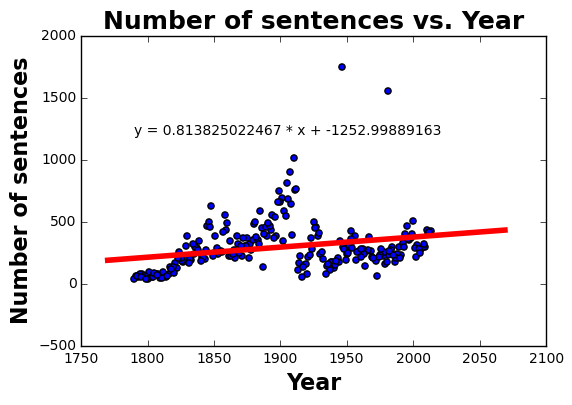

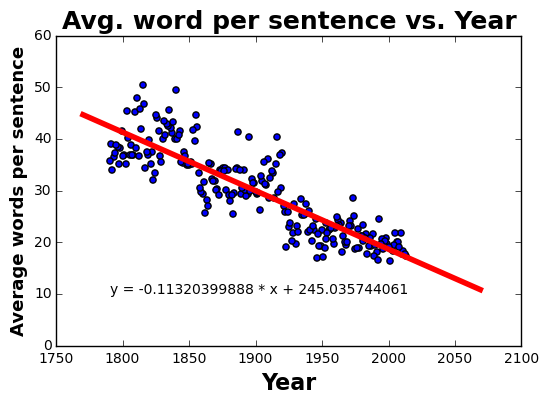

In [51]:
# Plotting data and linear regression on the same plot
# Axes are labeled

times1 = [i+ 1770 for i in range(300)]
num_sentences = np.dot(betas1[0], times1) + betas1[1]
times2 = [i+ 1770 for i in range(300)]
average_sentence_length = np.dot(betas2[0], times2) + betas2[1]

plt.plot(times1,num_sentences, lw=4, c='red')
plt.scatter(speech[:,0], speech[:,1])
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Number of sentences', fontsize=16, fontweight='bold')

plt.text(1790,1200,'y = %s * x + %s' % (str(betas1[0]), str(betas1[1])))
plt.title('Number of sentences vs. Year', fontsize=18, fontweight='bold')
plt.figure()
plt.plot(times2, average_sentence_length, lw=4, c='red')
plt.scatter(speech[:,0], speech[:,2])
plt.text(1790,10,'y = %s * x + %s' % (str(betas2[0]), str(betas2[1])))
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Average words per sentence', fontsize=13, fontweight='bold')
plt.title('Avg. word per sentence vs. Year', fontsize=18, fontweight='bold')

## Qualitative Assessments

Qualitative assessment of Year vs. number of sentences per SOU:


1) From 1790 to early 1900s, the number of sentences per SOU increased dramatically.

2) Aside from a couple of outliers, from early 1900s to present, the number of sentences per SOU has been increasing very moderately.

Qualitative assessment of Year vs. Avg words per sentence:

3) Avg words per sentences has decreased steadily per year.

4) This trend makes sense because our speech and writing evolved towards using shorter and shorter sentences over years.


Overall, the number of sentences slightly increased over the years and avg words per sentences decreased. This is just speculation, but maybe the fact that avg words per sentence decreased caused the number of sentences to increase to deliever a similar message.

## Part C

Now, compute two regressions of the total number of words in a SOU versus year–one
for the years 1790 to 1912, another for the years 1913 to the present

In [52]:
# Defining a function that'll be using to finding total number of words per SOU
def find_total_number_words(x):
    return int(len(x))

In [53]:
# filtering speeches by years
# 1 RDD for 1790 to 1912 and another RDD for 1913 to present

speeches1790to1912 = speeches.filter(speeches['year'] <= 1912)
speeches1913toPresent = speeches.filter(speeches['year'] > 1912)

Data1790to1912 = speeches1790to1912.rdd.map(lambda x: [[int(x['year']), \
                                      find_total_number_words(x['text'].split(' '))]]).reduce(lambda a, b: a + b)
Data1913toPresent = speeches1913toPresent.rdd.map(lambda x: [[int(x['year']), \
                                      find_total_number_words(x['text'].split(' '))]]).reduce(lambda a, b: a + b)

Data1790to1912 = np.array(Data1790to1912)
Data1913toPresent = np.array(Data1913toPresent)


In [54]:
# Running Linear Regression
# X1,Y1,left1, right1 are for 1790 to 1912
# X2,Y2,left2,right2 are for 1913 to present

X1 = np.c_[np.array(Data1790to1912[:,0]), np.ones(len(Data1790to1912[:,0]))]
Y1 = np.array(Data1790to1912[:,1])
X2 = np.c_[np.array(Data1913toPresent[:,0]), np.ones(len(Data1913toPresent[:,0]))]
Y2 = np.array(Data1913toPresent[:,1])

left1 = np.dot(X1.transpose(), X1)
right1 = np.dot(X1.transpose(), Y1)
left2 = np.dot(X2.transpose(), X2)
right2 = np.dot(X2.transpose(), Y2)

betas1 = np.linalg.solve(left1, right1.transpose())
betas2 = np.linalg.solve(left2, right2.transpose())

(0, 40000)

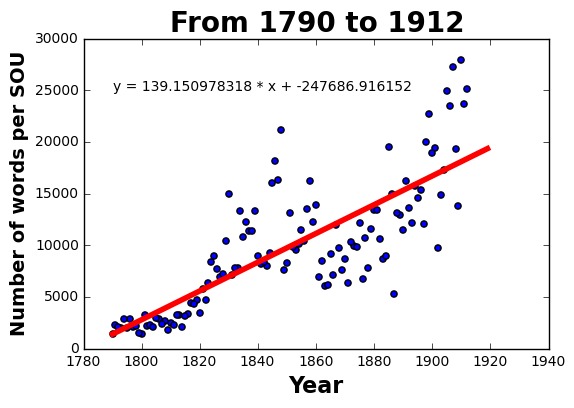

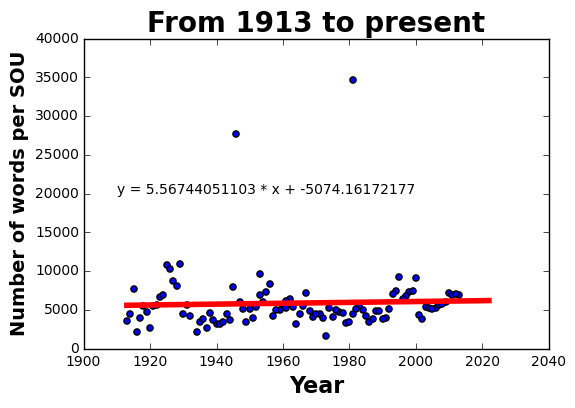

In [58]:
# Again, just plotting the results from above regression results

times1 = [i+ 1790 for i in range(130)]
From1790to1912 = np.dot(betas1[0], times1) + betas1[1]
times2 = [i+ 1913 for i in range(110)]
From1913toPresent = np.dot(betas2[0], times2) + betas2[1]

plt.plot(times1, From1790to1912, lw=4, c='red')
plt.scatter(Data1790to1912[:,0], Data1790to1912[:,1])
plt.title('From 1790 to 1912', fontsize=20, fontweight='bold')
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Number of words per SOU', fontsize=14, fontweight='bold')
plt.text(1790,25000,'y = %s * x + %s' % (str(betas1[0]), str(betas1[1])))
plt.ylim([0,30000])
plt.figure()
plt.plot(times2, From1913toPresent, lw=4, c='red')
plt.scatter(Data1913toPresent[:,0], Data1913toPresent[:,1])
plt.xlabel('Year', fontsize=16, fontweight='bold')
plt.ylabel('Number of words per SOU', fontsize=14, fontweight='bold')
plt.title('From 1913 to present', fontsize=20, fontweight='bold')
plt.text(1910,20000,'y = %s * x + %s' % (str(betas2[0]), str(betas2[1])))
plt.ylim([0,40000])

## Qualitative Analysis


1) From 1790 to 1912, the number of words used per SOU increased dramatically. Starting from below 5000 words per SOU to reaching approximately 26000 words per SOU

2) From 1913 to present, the number of words used per SOU has been more or less constant, hovering around 5000 words per SOU. There were a few exceptions in early 1940 and early 1980 that resulted in long SOUs reaching more than 25000 words per SOU.


According to wikipedia, the SOU addresses were initially given as speeches to the congress, but Thomas Jefferson stopped doing it in 1801. The address was written and sent to the congress to be read by a clerk until in 1913 Woodrow Wilson decided re-establish the practice of giving a speech. This explains why the SOU addresses were getting longer and longer from 1790 to 1912. Since it was written, the presidents wrote as much as they can for it to be read by the clerk to the congress. The written SOUs would be too long for presidents to read themselves. However, after the practice of giving SOU speeches was re-established, the number of words per SOu stayed mostly constant. In early 1940, World War II happened, so I imagine the president had a lot of things to say, and in early 1980, Jimmy Carter sent in a written SOU, which is why the SOU address was so long again.

## Part D

#### Which President has the longest sentences on average

In [86]:
# Defining functions to be used for finding longest and shortest sentences on average

def shortest(comp1, comp2):
    president1, wcnt1 = comp1
    president2, wcnt2 = comp2
    if wcnt1 < wcnt2:
        return (president1, wcnt1)
    else:
        return (president2, wcnt2)
def longest(comp1, comp2):
    president1, wcnt1 = comp1
    president2, wcnt2 = comp2
    if wcnt1 > wcnt2:
        return (president1, wcnt1)
    else:
        return (president2, wcnt2)


In [87]:
# MapReduce to make tuples of (president, avg word per sentence)
speech = speeches.rdd.map(lambda x: (x['president'], \
                                      (find_total_number_words(x['text'].split(' ')),\
                                       find_num_sentences(x['text'].split('.'))))).\
                                    reduceByKey(lambda a,b: (a[0] + b[0], a[1] + b[1])).\
                                    mapValues(lambda x:(float(x[0])/float(x[1])))

In [92]:
# Longest sentences on Average
longest_pres = speech.reduce(longest)
print "President with the longest sentences on average:", longest_pres[0]


President with the longest sentences on average: James Madison


In [93]:
# Shortest sentences on Average
shortest_pres = speech.reduce(shortest)
print "President with the shortest sentences on average:", shortest_pres[0]


President with the shortest sentences on average: George Bush


In [97]:
# putting values from RDD tuples into numpy arrays
presidents, avgwcnt = zip(*speech.collect())
avgwcnt = np.array(avgwcnt)

Calculate median, 25% and 75% quantiles across all Presidents

In [98]:
#Calculate median
print "Median:", np.median(avgwcnt)

#Calculate 25% quantile
print "25% quantile:", np.percentile(avgwcnt, 25)

#Calculate 75% quantile
print "75% quantile:", np.percentile(avgwcnt, 75)

Median: 30.1313958248
25% quantile: 21.4325711619
75% quantile: 34.296377607


What was the longest and shortest sentence ever spoken (or written) in a SOU?

## Longest sentence

In [113]:
# Splitting all texts into tuples of (sentence, length of sentence)
# And sorting them by length of sentence and taking a gander at the first 10 
speech = speeches.rdd.map(lambda x: (x['text'].split('.')))\
                     .map(lambda x: (x[0], find_total_number_words(x[0].split(' '))))\
                     .reduceByKey(lambda a,b: a)\
                     .sortBy(lambda x: x[1]*-1.).take(10)

print "Longest sentence:"            
print speech[0][0]

Longest sentence:
GENTLEMEN OF THE CONGRESS:

 

In fulfilling at this time the duty laid upon me by the Constitution of communicating to you from time to time information of the state of the Union and recommending to your consideration such legislative measures as may be judged necessary and expedient, I shall continue the practice, which I hope has been acceptable to you, of leaving to the reports of the several heads of the executive departments the elaboration of the detailed needs of the public service and confine myself to those matters of more general public policy with which it seems necessary and feasible to deal at the present session of the Congress


## Shortest sentence

In [114]:
speech = speeches.rdd.map(lambda x: (x['text'].split('.')))\
                     .map(lambda x: (x[0], find_total_number_words(x[0].split(' '))))\
                     .reduceByKey(lambda a,b: a)\
                     .sortBy(lambda x: x[1]).take(10)

print speech

[(u'Mr', 1), (u'MR', 1), (u'The President', 2), (u'Madam Speaker, Mr', 3), (u'Thank you all', 3), (u'[\r\n\r\nReleased January 21, 1946', 4), (u'Thank you very much', 4), (u'[Delivered in person before a joint session] \r\n\r\nMr', 8), (u'[As delivered in person before a joint session] \r\n\r\nMr', 9), (u'[As delivered in person before a joint session ] \r\n\r\nMr', 10)]


In [115]:
# Looking through that list, there are some incomplete sentences including prefix.
# The most reasonable sentence that's the shorteest seems to be "Thank you all"

print "Shortest sentence:" , speech[4][0]

Shortest sentence: Thank you all
